## Create and test ion channel model

In [1]:
from experiments.ina_sakakibara import (sakakibara_iv,
                                        sakakibara_iv_Nao2 ,
                                        sakakibara_iv_Nao5 ,
                                        sakakibara_iv_Nao20 ,
                                        sakakibara_act,
                                        sakakibara_inact,
                                        sakakibara_inact_kin_1,
                                        sakakibara_inact_kin_2,
                                        sakakibara_inact_kin_80,
                                        sakakibara_recov,
                                        sakakibara_recov_100,
                                        sakakibara_recov_kin)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyabc import Distribution, RV
import os, tempfile
import logging
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize
from ionchannelABC import theoretical_population_size
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from pyabc import History
from ionchannelABC import plot_sim_results
import seaborn as sns
from ionchannelABC import plot_parameters_kde
from ionchannelABC.experiment import setup

INFO:myokit:Loading Myokit version 1.28.4


In [2]:
modelfile = 'models/Courtemanche_iNa.mmt'

In [23]:
observations, model, summary_statistics = setup(modelfile,
                                                sakakibara_inact_kin_80)

In [24]:
assert len(observations)==len(summary_statistics(model({})))

## Set limits and generate uniform initial priors

In [25]:
"""
limits = {'ina.c1_h': (0,50),
          'ina.a1_h': (-10,10),
          'ina.a2_h': (0,20),
          'ina.a3_h': (0,100),
          'ina.b1_h': (0,10),
          'ina.b2_h': (0,100),
          'ina.b3_h': (0,50),
          'ina.b4_h': (0,20),
          'ina.b5_h': (0.0001,1),
          'ina.b6_h': (0.000001,0.001),
          'ina.b7_h': (0,1)}




prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})
                        """

'\nlimits = {\'ina.c1_h\': (0,50),\n          \'ina.a1_h\': (-10,10),\n          \'ina.a2_h\': (0,20),\n          \'ina.a3_h\': (0,100),\n          \'ina.b1_h\': (0,10),\n          \'ina.b2_h\': (0,100),\n          \'ina.b3_h\': (0,50),\n          \'ina.b4_h\': (0,20),\n          \'ina.b5_h\': (0.0001,1),\n          \'ina.b6_h\': (0.000001,0.001),\n          \'ina.b7_h\': (0,1)}\n\n\n\n\nprior = Distribution(**{key: RV("uniform", a, b - a)\n                        for key, (a,b) in limits.items()})\n                        '

In [40]:
          
limits = {'ina.g_Na' : (0.01,100),
          'ina.a1_m': (0,100),
          'ina.a2_m': (-50,50),
          'ina.a3_m': (-50,50),
          'ina.a4_m': (-50,50),
          'ina.b1_m': (-50,50),
          'ina.b2_m': (0,100)}
            
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [41]:
"""
limits = {'ina.c1_j': (0,100),
          'ina.a1_j': (100000,300000),
          'log_ina.a2_j': (-4,1),
          'log_ina.a3_j': (-6,-3),
          'log_ina.a4_j': (-4,0),
          'ina.a5_j': (0,50),
          'ina.a6_j': (0.001,10),
          'ina.a7_j': (50,150),
          'ina.b1_j': (0.001,10),
          'log_ina.b2_j': (-8,-5),
          'log_ina.b3_j': (-3,1),
          'ina.b4_j': (0,50),
          'log_ina.b5_j': (-4,0),
          'log_ina.b6_j': (-4,0),
          'log_ina.b7_j': (-4,0),
          'ina.b8_j': (20,70)}

prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})
"""

'\nlimits = {\'ina.c1_j\': (0,100),\n          \'ina.a1_j\': (100000,300000),\n          \'log_ina.a2_j\': (-4,1),\n          \'log_ina.a3_j\': (-6,-3),\n          \'log_ina.a4_j\': (-4,0),\n          \'ina.a5_j\': (0,50),\n          \'ina.a6_j\': (0.001,10),\n          \'ina.a7_j\': (50,150),\n          \'ina.b1_j\': (0.001,10),\n          \'log_ina.b2_j\': (-8,-5),\n          \'log_ina.b3_j\': (-3,1),\n          \'ina.b4_j\': (0,50),\n          \'log_ina.b5_j\': (-4,0),\n          \'log_ina.b6_j\': (-4,0),\n          \'log_ina.b7_j\': (-4,0),\n          \'ina.b8_j\': (20,70)}\n\nprior = Distribution(**{key: RV("uniform", a, b - a)\n                        for key, (a,b) in limits.items()})\n'

## Run ABC calibration

In [42]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "crm_ina_testing_gate_m.db"))

In [43]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [44]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 128 particles


In [45]:

abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(1000), # Small pop to test
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=20),
             sampler=MulticoreEvalParallelSampler(n_procs=12),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9999999999999998, '1': 0.9999999999999998, '2': 0.9999999999999998, '3': 0.9999999999999998, '4': 0.9999999999999998, '5': 0.9999999999999998, '6': 0.9999999999999998, '7': 0.9999999999999998, '8': 0.9999999999999998, '9': 0.9999999999999998, '10': 0.9999999999999998}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=20, quantile_multiplier=1


In [46]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [47]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=5, start_time=2019-08-22 14:11:32.452230, end_time=None)>


In [48]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=10, min_acceptance_rate=0.005)

INFO:ABC:t:0 eps:20
DEBUG:ABC:now submitting population 0
/home/brm18/.local/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/experiment.py:212: UserWarning: Could not set value of ina.a2_m
/home/brm18/.local/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/experiment.py:219: ResourceWarning: unclosed file <_io.TextIOWrapper name=57 mode='w+' encoding='UTF-8'>
/home/brm18/.local/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/experiment.py:219: ResourceWarning: unclosed file <_io.TextIOWrapper name=58 mode='w+' encoding='UTF-8'>


KeyboardInterrupt: 

# Results analysis

/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/

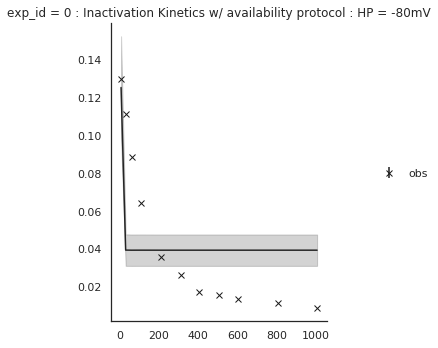

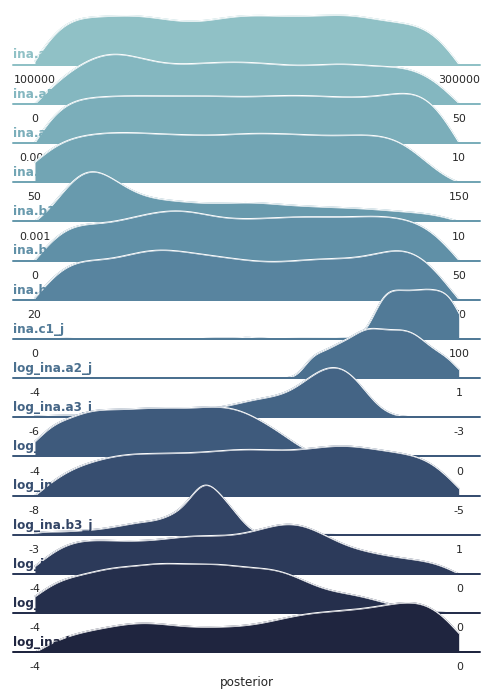

In [35]:
history = History(db_path)
history.id = 3 # 2 correponds to the recovery curve : j gate
# 3 : correponds to the availability (inact_kin_80) : j gate, but failed to retrieve a correct curve
# 5 : correponds to the availability (inact_kin_80) : m gate, still running

df, w = history.get_distribution(m=0)

grid1 = plot_sim_results(modelfile,sakakibara_inact_kin_80 ,df=df, w=w) 
grid2 = plot_parameters_kde(df, w, limits, aspect=12,height=0.6)

In [22]:
grid1.savefig('results/Ina Crm model/ina_crm_exp_availability_saka_pop_10000.pdf')
grid2.savefig('results/Ina Crm model/ina_crm_post_availability_saka_pop_10000.pdf')